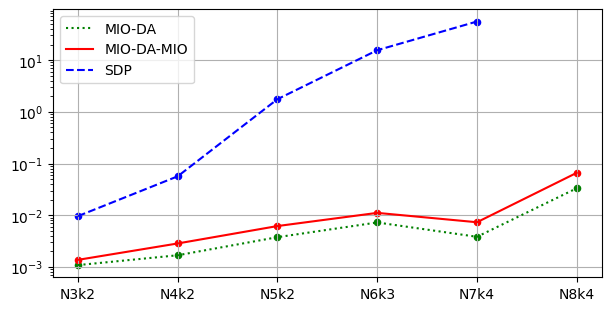

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

colors = {'sdp':'blue', 'mio_cdae':'green', 'mio_cdae_mio':'red'}
labels = {'sdp':'SDP', 'mio_cdae_mio':'MIO-DA-MIO', 'mio_cdae':'MIO-DA'}
line_style = {'sdp':'--', 'mio_cdae':':', 'mio_cdae_mio':'-'}

with h5py.File('runtimes.h5', 'r') as f:

    fig, (ax) = plt.subplots(1, 1, layout="constrained", figsize=(6, 3))
    
    keys = [key for key in f.keys() if key != 'qmp_ml_compiled']

    for key in keys:
        color = colors[key]
        
        
        means  = {k:v[:].mean() for k,v in f[key].items() if not v[:].mean() == 0 }
        stds   = {k:v[:].std() for k,v in f[key].items() if not v[:].mean() == 0 }
        
        means_arr = np.array(list(means.values()))
        stds_arr = np.array(list(stds.values()))
        ax.scatter(means.keys(), means_arr, s=20, c=color)
        ax.plot(means.keys(), means_arr, line_style[key],label=labels[key], c=color)   
        # ax.fill_between(means.keys(), means_arr - stds_arr, means_arr + stds_arr, alpha=0.15, color=color)
    
ax.grid()
ax.set_yscale('log')
ax.legend(loc='upper left')
plt.show()
